In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima import model_selection
from datetime import datetime
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose
file_path = "RBRTEd.xls"
df = pd.read_excel(file_path)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2023-12-31')]
df = df.rename(columns={'Europe Brent Spot Price FOB (Dollars per Barrel)': 'Price'})
df.reset_index(drop=True, inplace=True)
# Now, set the frequency
df.index.freq = 'MS'
#df = pd.read_excel("C:/Users/caoch/Downloads/RBRTEm.xls", index_col='Date')

print(df.columns)
#df['Date'] = pd.to_datetime(df['Date'], format='%B-%Y').dt.strftime('%Y-%m-01')
#df.index.freq='MS'
df.head()

Index(['Date', 'Price'], dtype='object')


,Date,Price
0,2018-01-02,66.65
1,2018-01-03,67.85
2,2018-01-04,68.73
3,2018-01-05,68.01
4,2018-01-08,68.48


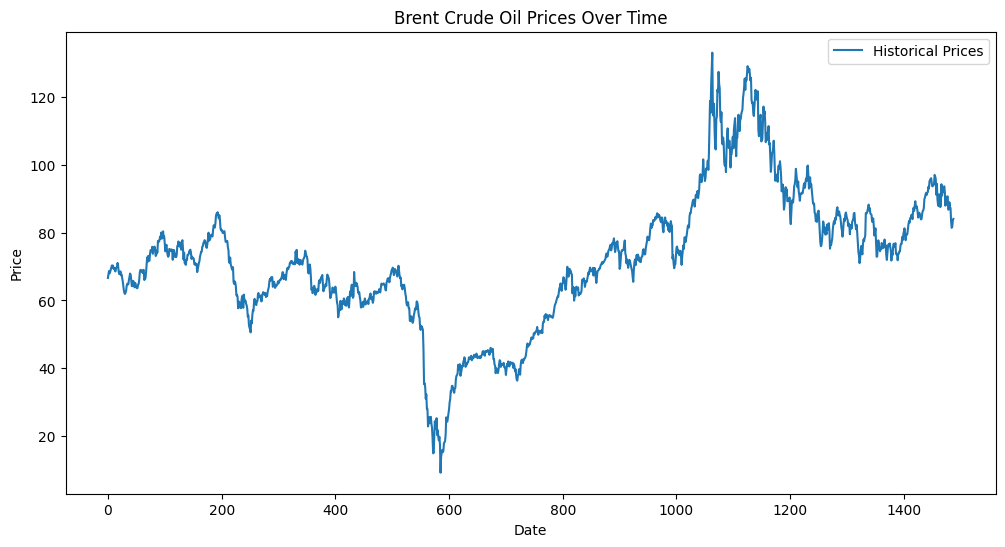

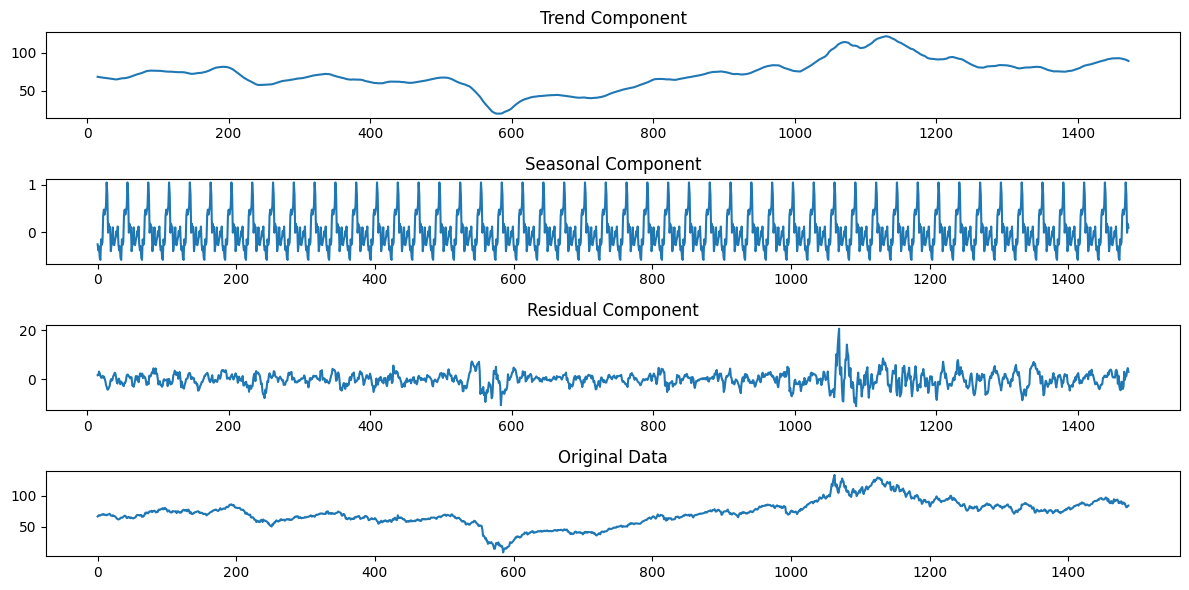

In [3]:
# Plot the historical data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Historical Prices')
plt.title('Brent Crude Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Perform seasonal decomposition (optional)
# You may decompose the data to understand trends and seasonality
decomposition = pm.arima.decompose(df['Price'], m=30, type_='additive')
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.subplot(413)
plt.plot(decomposition.random)
plt.title('Residual Component')
plt.subplot(414)
plt.plot(df['Price'])
plt.title('Original Data')
plt.tight_layout()
plt.show()



In [4]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]
stepwise_fit = auto_arima(df['Price'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()


c:\Users\caoch\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6137.474, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6138.805, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6138.719, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6135.531, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6139.492, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.346 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1488
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3066.765
Date:                Mon, 20 Nov 2023   AIC                           6135.531
Time:                        10:45:14   BIC                           6140.835
Sample:                             0   HQIC                          6137.508
                               - 1488                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.6215      0.060     60.786      0.000       3.505       3.738
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):              4126.97
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               3.95   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(0,1,0) MSE Error: 50.56775268


c:\Users\caoch\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


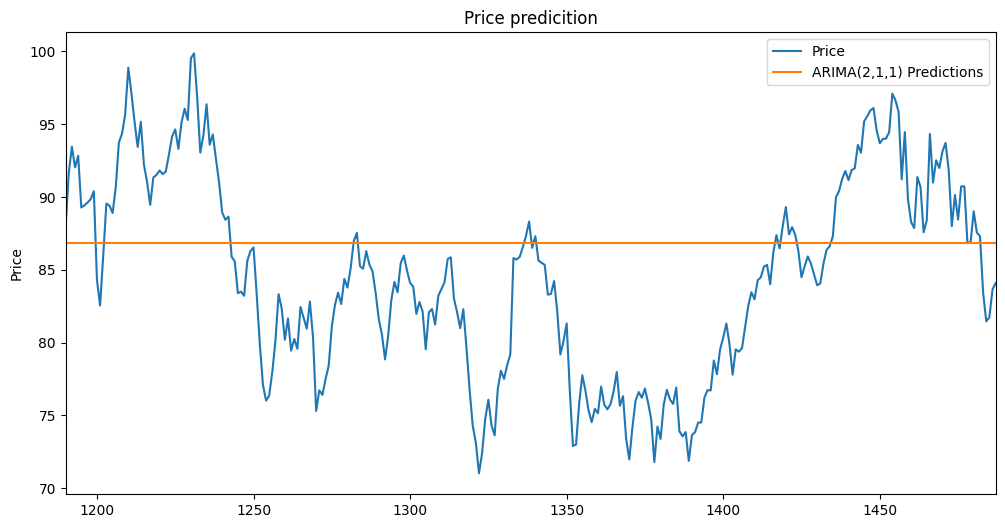

In [5]:
model = ARIMA(train_data['Price'],order=(0, 1, 0))
results = model.fit()
results.summary()

# Make predictions on the test data
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Predictions')

title = 'Price predicition'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = test_data['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_data['Price'], predictions)
print(f'ARIMA(0,1,0) MSE Error: {error:11.10}')

ARIMA(0,1,0) MSE Error: 50.18606924


c:\Users\caoch\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


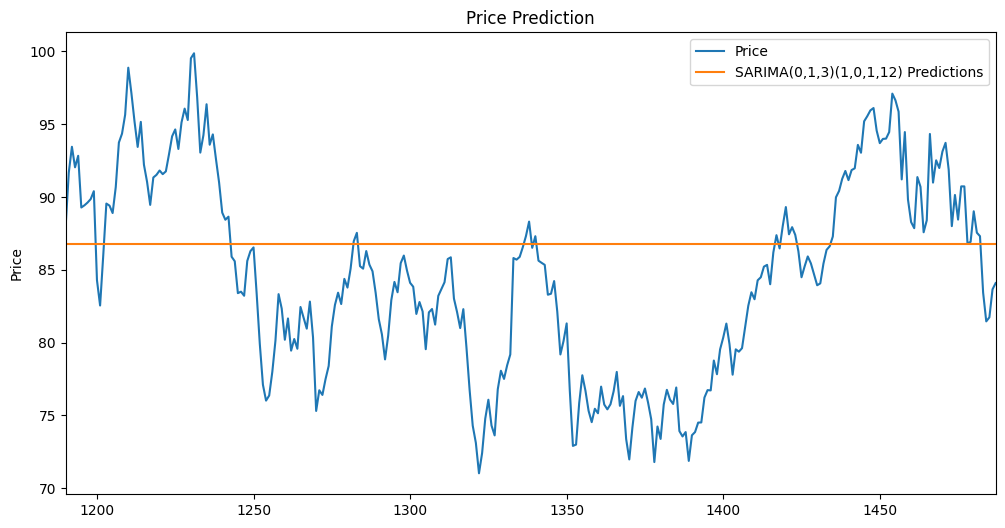

In [6]:
model = ARIMA(train_data['Price'],order=(0, 1, 1))
results = model.fit()
results.summary()
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')
title = 'Price Prediction'
ylabel='Price'
xlabel=''

ax = test_data['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
error = mean_squared_error(test_data['Price'], predictions)
print(f'ARIMA(0,1,0) MSE Error: {error:11.10}')